In [1]:
pip install dask_ml

Note: you may need to restart the kernel to use updated packages.


In [2]:
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
pbar = ProgressBar(); pbar.register()

0. Initial Setup: Explore & Persist
Before transformations, persist the DataFrame:

In [3]:
dic = {
    'Provider': 'category',
    'Race_mode': 'category',
    'State_mode': 'category',
    'County_mode': 'category',
    'PotentialFraud': 'category',
    'Bene_Age_Sum': 'float64',
    'TotalClaims': 'float64',
    'AttendingPhysician_TotalClaims': 'float64',
    'Prv_Physician_Count': 'float64',
    'Provider_Insurance_Claim_Reimbursement_Amt': 'float64',
    'Provider_Total_Patients': 'float64',
    'Provider_Total_ChronicCond_Alzheimer_Patients': 'float64',
    'Provider_Total_ChronicCond_Heartfailure_Patients': 'float64',
    'Provider_Total_ChronicCond_KidneyDisease_Patients': 'float64',
    'Provider_Total_ChronicCond_Cancer_Patients': 'float64',
    'Provider_Total_ChronicCond_ObstrPulmonary_Patients': 'float64',
    'Provider_Total_ChronicCond_Depression_Patients': 'float64',
    'Provider_Total_ChronicCond_Diabetes_Patients': 'float64',
    'Provider_Total_ChronicCond_IschemicHeart_Patients': 'float64',
    'Provider_Total_ChronicCond_Osteoporasis_Patients': 'float64',
    'Provider_Total_ChronicCond_rheumatoidarthritis_Patients': 'float64',
    'Provider_Total_ChronicCond_stroke_Patients': 'float64',
    'ClmAdmitDiagnosisCode_Count': 'float64',
    'ClmDiagnosisCode_1_Count': 'float64',
    'ClmDiagnosisCode_2_Count': 'float64',
    'ClmDiagnosisCode_3_Count': 'float64',
    'ClmAdmitDiagnosisCode_Most_Frequent': 'category',
    'ClmDiagnosisCode_1_Most_Frequent': 'category',
    'ClmDiagnosisCode_2_Most_Frequent': 'category',
    'ClmDiagnosisCode_3_Most_Frequent': 'category',
    'AttendingPhysician_Most_Frequent': 'category',
    'OperatingPhysician_Most_Frequent': 'category',
    'OtherPhysician_Most_Frequent': 'category',
    'Avg_allocated_Amount_Per_Provider': 'float64',
    'Avg_Deductible_Amt_Paid_Per_Provider': 'float64',
    'Avg_InscClaimAmtReimbursed_Per_Provider': 'float64',
    'perc_allocated_used': 'float64',
    'prv_avg_claims': 'float64',
    'prv_avg_claim_cost_indicator': 'float64',
    'prv_avg_claims_indicator': 'float64'
}


In [4]:
merged_path = "s3://medicare-fraud-data-25-05-2025/merged_ready/train/*.csv"
df_train = dd.read_csv(merged_path,dtype=dic, assume_missing=True)


In [5]:
df_train = df_train.persist()

[########################################] | 100% Completed | 413.29 ms


In [6]:
dtypes_long = df_train.dtypes.reset_index()
dtypes_long.columns = ['column_name', 'dtype']

# Ganze Tabelle anzeigen, unabhängig von Länge
print(dtypes_long.to_string(index=False))

                                            column_name    dtype
                                               Provider category
                                      ClaimDuration_sum  float64
                                     ClaimDuration_mean  float64
                                      ClaimDuration_std  float64
                                      ClaimDuration_max  float64
                                      ClaimDuration_min  float64
                                   HospitalDuration_sum  float64
                                  HospitalDuration_mean  float64
                                   HospitalDuration_std  float64
                                   HospitalDuration_max  float64
                                   HospitalDuration_min  float64
                                  DeductibleAmtPaid_sum  float64
                                 DeductibleAmtPaid_mean  float64
                                  DeductibleAmtPaid_std  float64
                         

In [7]:

print(df_train.shape)         # returns a (delayed) tuple, e.g. (n_rows, n_cols)
print(df_train.head(3)) 

(<dask_expr.expr.Scalar: expr=FromGraph(d7267b5).size() // 95, dtype=int64>, 95)
[                                        ] | 0% Completed | 365.33 us

[########################################] | 100% Completed | 103.46 ms
   Provider  ClaimDuration_sum  ClaimDuration_mean  ClaimDuration_std  \
0  PRV52145              335.0            1.367347           4.708267   
1  PRV55104               72.0            1.384615           4.822959   
2  PRV54894             1024.0            4.471616           6.659338   

   ClaimDuration_max  ClaimDuration_min  HospitalDuration_sum  \
0               20.0                0.0                   0.0   
1               20.0                0.0                   0.0   
2               35.0                0.0                 918.0   

   HospitalDuration_mean  HospitalDuration_std  HospitalDuration_max  ...  \
0                    NaN                   NaN                   NaN  ...   
1                    NaN                   NaN                   NaN  ...   
2               6.652174              7.147714                  35.0  ...   

   AttendingPhysician_Most_Frequent  OperatingPhysician_Most_Freq

In [8]:
missing = df_train.isnull().sum().compute()
print(missing[missing > 0])


[########################################] | 100% Completed | 101.74 ms
ClaimDuration_std                       240
HospitalDuration_mean                  3318
HospitalDuration_std                   3533
HospitalDuration_max                   3318
HospitalDuration_min                   3318
DeductibleAmtPaid_mean                    1
DeductibleAmtPaid_std                   245
DeductibleAmtPaid_max                     1
DeductibleAmtPaid_min                     1
ClmAdmitDiagnosisCode_Most_Frequent     452
ClmDiagnosisCode_1_Most_Frequent          5
ClmDiagnosisCode_2_Most_Frequent         94
ClmDiagnosisCode_3_Most_Frequent        210
dtype: int64


In [9]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
from dask_ml.preprocessing import StandardScaler

class MedicarePreprocessor:
    def __init__(self, df: dd.DataFrame):
        self.df = df

        self.cat_cols = [
            #"Provider",
            "Race_mode",
            "State_mode",
            "County_mode",
            #"PotentialFraud",
            "ClmAdmitDiagnosisCode_Most_Frequent",
            "ClmDiagnosisCode_1_Most_Frequent",
            "ClmDiagnosisCode_2_Most_Frequent",
            "ClmDiagnosisCode_3_Most_Frequent",
            "AttendingPhysician_Most_Frequent",
            "OperatingPhysician_Most_Frequent",
            "OtherPhysician_Most_Frequent"
        ]

        self.num_cols = [
            col
            for col, dtype in df.dtypes.items()
            if (dtype == "float64" and col != "PotentialFraud" and col not in self.cat_cols)
        ]

        self.target_col = "PotentialFraud"

    def drop_unused_columns(self, drop_cols: list = None):
        if drop_cols is None:
            drop_cols = [
                "ClmAdmitDiagnosisCode_Most_Frequent",
                "ClmDiagnosisCode_2_Most_Frequent",
                "ClmDiagnosisCode_3_Most_Frequent",
                "AttendingPhysician_Most_Frequent"
            ]
        to_drop = [c for c in drop_cols if c in self.df.columns]
        if to_drop:
            self.df = self.df.drop(columns=to_drop)
        self.cat_cols = [c for c in self.cat_cols if c not in to_drop]
        return self

    def fill_missing(self):
        # 1) Compute all numeric means in one shot
        means = self.df[self.num_cols].mean().compute()  # pandas.Series of means
        means_dict = {col: float(means[col]) for col in self.num_cols}

        # 2) Cast cat columns to string, then fill all missing with "MISSING"
        for col in self.cat_cols:
            self.df[col] = self.df[col].astype("string")

        fill_dict = means_dict.copy()
        for col in self.cat_cols:
            fill_dict[col] = "MISSING"

        # 3) One fillna call for everything:
        self.df = self.df.fillna(fill_dict)
        return self

    def encode_categoricals(self):
        # 1) Cast all cat columns to category dtype
        for col in self.cat_cols:
            self.df[col] = self.df[col].astype("category")

        # 2) One global categorize/shuffle
        self.df = self.df.categorize(columns=self.cat_cols)

        # 3) One pass to convert each cat to codes
        def _apply_cat_codes(pdf):
            pdf2 = pdf.copy()
            for c in self.cat_cols:
                pdf2[c] = pdf2[c].cat.codes.astype("int64")
            return pdf2

        self.df = self.df.map_partitions(_apply_cat_codes)
        return self

    def clip_outliers(self, lower_quantile=0.01, upper_quantile=0.99):
        for col in self.num_cols:
            q_low = self.df[col].quantile(lower_quantile).compute()
            q_high = self.df[col].quantile(upper_quantile).compute()
            self.df[col] = self.df[col].clip(lower=q_low, upper=q_high)
        return self

    def feature_engineering(self):
        def _safe_divide_avg_cost(pdf):
            num = pdf["Provider_Insurance_Claim_Reimbursement_Amt"]
            den = pdf["TotalClaims"]
            return pd.Series(
                np.where(den == 0, 0.0, num / den),
                index=pdf.index,
                name="avg_cost_per_claim"
            )

        self.df["avg_cost_per_claim"] = self.df.map_partitions(_safe_divide_avg_cost)
        self.num_cols.append("avg_cost_per_claim")

        def _pct_chronic_alz(pdf):
            num = pdf["Provider_Total_ChronicCond_Alzheimer_Patients"]
            den = pdf["Provider_Total_Patients"]
            return pd.Series(
                np.where(den == 0, 0.0, num / den),
                index=pdf.index,
                name="perc_chronic_alz"
            )

        self.df["perc_chronic_alz"] = self.df.map_partitions(_pct_chronic_alz)
        self.num_cols.append("perc_chronic_alz")

        return self

    def scale_numeric_features(self):
        exclude = {self.target_col, "Provider"}
        to_scale = [c for c in self.num_cols if c not in exclude]

        if to_scale:
            scaler = StandardScaler()
            scaled_df = scaler.fit_transform(self.df[to_scale])
            self.df = dd.concat(
                [self.df.drop(columns=to_scale), scaled_df],
                axis=1
            )
        return self

    def get_processed_df(self) -> dd.DataFrame:
        self.df = self.df.persist()
        return self.df


In [10]:
# 2.3) Instantiate the preprocessor
preprocessor = MedicarePreprocessor(df_train)

# 2.4) Chain the preprocessing steps in order
df_train_processed = (
    preprocessor
      .drop_unused_columns()      # drop columns you don’t plan to use
      .fill_missing()             # impute numeric → mean, category → mode
      .encode_categoricals()      # convert each category to integer codes
      .feature_engineering()      # OPTIONAL: add new ratio features
      .scale_numeric_features()   # standard‐scale every numeric column
      .get_processed_df()         # persist & retrieve final Dask DataFrame
)


[                                        ] | 0% Completed | 173.09 us

[########################################] | 100% Completed | 101.99 ms
[########################################] | 100% Completed | 102.33 ms


/home/ec2-user/.venv/lib64/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/home/ec2-user/.venv/lib64/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(


[########################################] | 100% Completed | 208.80 ms
[########################################] | 100% Completed | 204.93 ms


In [11]:
print(df_train_processed.dtypes)
print(df_train_processed.head(3))


Provider                        category
Race_mode                          int64
State_mode                         int64
County_mode                        int64
PotentialFraud                  category
                                  ...   
prv_avg_claims                   float64
prv_avg_claim_cost_indicator     float64
prv_avg_claims_indicator         float64
avg_cost_per_claim               float64
perc_chronic_alz                 float64
Length: 93, dtype: object
[########################################] | 100% Completed | 102.09 ms
   Provider  Race_mode  State_mode  County_mode PotentialFraud  \
0  PRV52145          0           1            9              0   
1  PRV55104          0          26           16              0   
2  PRV54894          0          26           58              1   

   ClmDiagnosisCode_1_Most_Frequent  OperatingPhysician_Most_Frequent  \
0                               277                                 0   
1                               277     

In [12]:
def save_dask_to_s3(df, path, file_format="csv", single_file=False, index=False):
    """
    Save a Dask DataFrame to S3 in CSV or Parquet format.
    
    Parameters:
        df (dask.DataFrame): The Dask DataFrame to save
        path (str): S3 path (e.g. s3://bucket/folder/)
        file_format (str): 'csv' or 'parquet'
        single_file (bool): Save as single file (only for small data)
        index (bool): Whether to save the index
    """
    if file_format == "csv":
        if single_file:
            df.compute().to_csv(path, index=index)
        else:
            df.to_csv(path + "part-*.csv", index=index)
    elif file_format == "parquet":
        df.to_parquet(path, write_index=index)
    else:
        raise ValueError("Unsupported file_format: choose 'csv' or 'parquet'")


In [13]:
prosessed_path = "s3://medicare-fraud-data-25-05-2025/processed_new/"
# Save the merged DataFrames to S3
save_dask_to_s3(df_train_processed, prosessed_path + "train/")
#save_dask_to_s3(df_train_processed, prosessed_path + "test/")

[                                        ] | 0% Completed | 167.79 us

[########################################] | 100% Completed | 1.12 sms


In [38]:
df_train_processed.columns

Index(['Provider', 'Race_mode', 'State_mode', 'County_mode', 'PotentialFraud',
       'ClmDiagnosisCode_1_Most_Frequent', 'OperatingPhysician_Most_Frequent',
       'OtherPhysician_Most_Frequent', 'ClaimDuration_sum',
       'ClaimDuration_mean', 'ClaimDuration_std', 'ClaimDuration_max',
       'ClaimDuration_min', 'HospitalDuration_sum', 'HospitalDuration_mean',
       'HospitalDuration_std', 'HospitalDuration_max', 'HospitalDuration_min',
       'DeductibleAmtPaid_sum', 'DeductibleAmtPaid_mean',
       'DeductibleAmtPaid_std', 'DeductibleAmtPaid_max',
       'DeductibleAmtPaid_min', 'IPAnnualReimbursementAmt_mean',
       'IPAnnualReimbursementAmt_max', 'IPAnnualDeductibleAmt_mean',
       'IPAnnualDeductibleAmt_max', 'OPAnnualReimbursementAmt_mean',
       'OPAnnualReimbursementAmt_max', 'OPAnnualDeductibleAmt_mean',
       'OPAnnualDeductibleAmt_max', 'ChronicCond_Alzheimer_sum',
       'ChronicCond_Alzheimer_mean', 'ChronicCond_Heartfailure_sum',
       'ChronicCond_Heartfailure_m

In [27]:
import fsspec

fs = fsspec.filesystem("s3")
fs.ls("medicare-fraud-data-25-05-2025/processed/train/")

['medicare-fraud-data-25-05-2025/processed/train/part-0.csv',
 'medicare-fraud-data-25-05-2025/processed/train/part-1.csv',
 'medicare-fraud-data-25-05-2025/processed/train/part-2.csv']

In [12]:
import dask.dataframe as dd

# 1) Suppose df_train_processed has columns ["Provider", …, "PotentialFraud"].
#    We’ll split it into two subsets: non-fraud (0) and fraud (1).

df_zero = df_train_processed[df_train_processed.PotentialFraud == 0]
df_one  = df_train_processed[df_train_processed.PotentialFraud == 1]

# 2) For each subset, call `.random_split([0.8, 0.2], random_state=42)` 
#    to get an 80/20 split within that class.

#    Note: random_split returns a list [train_part, test_part].
train_zero, test_zero = df_zero.random_split([0.8, 0.2], random_state=42)
train_one,  test_one  = df_one.random_split([0.8, 0.2], random_state=42)

# 3) Concatenate the “zero” and “one” pieces to form overall train/test sets:
df_train = dd.concat([train_zero, train_one])
df_test  = dd.concat([test_zero,  test_one])

# 4) (Optional) Shuffle each combined DataFrame so the 0/1 examples are interleaved
df_train = df_train.shuffle(on="Provider", random_state=42)
df_test  = df_test.shuffle(on="Provider", random_state=42)

# 5) Finally, separate X_train/y_train and X_test/y_test:
X_train = df_train.drop(columns=["Provider", "PotentialFraud"])
y_train = df_train["PotentialFraud"]

X_test  = df_test.drop(columns=["Provider", "PotentialFraud"])
y_test  = df_test["PotentialFraud"]

# 6) Persist each:
X_train = X_train.persist()
y_train = y_train.persist()
X_test  = X_test.persist()
y_test  = y_test.persist()


[########################################] | 100% Completed | 205.01 ms
[########################################] | 100% Completed | 102.58 ms
[########################################] | 100% Completed | 204.99 ms
[########################################] | 100% Completed | 103.20 ms


In [15]:
from dask.distributed import Client

# If you already have a scheduler address, you can pass it here. 
# Otherwise, this will start a local cluster with several threads/processes.
client = Client()


2025-06-06 19:46:54,985 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 510bb83d8ed28650cbbe392b1e569b09 initialized by task ('shuffle-transfer-510bb83d8ed28650cbbe392b1e569b09', 5) executed on worker tcp://127.0.0.1:41141
2025-06-06 19:46:55,304 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 510bb83d8ed28650cbbe392b1e569b09 deactivated due to stimulus 'task-finished-1749239215.301977'
2025-06-06 19:49:22,267 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 510bb83d8ed28650cbbe392b1e569b09 initialized by task ('shuffle-transfer-510bb83d8ed28650cbbe392b1e569b09', 4) executed on worker tcp://127.0.0.1:39285
2025-06-06 19:49:22,613 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 510bb83d8ed28650cbbe392b1e569b09 deactivated due to stimulus 'task-finished-1749239362.6110141'
2025-06-06 19:49:26,529 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 510bb83d8ed28650cbbe392b1e569b09 initialized by task ('shuffle-transfer-510bb83d8ed2865

In [16]:
pip install xgboost[dask]


Note: you may need to restart the kernel to use updated packages.


In [17]:
import xgboost as xgb

# 3.2.1) Create DaskDMatrix for train and test
dtrain = xgb.dask.DaskDMatrix(client, X_train, y_train)
dtest  = xgb.dask.DaskDMatrix(client, X_test, y_test)


In [18]:
# Count negatives and positives in the training set
neg_count = (y_train == 0).sum().compute()
pos_count = (y_train == 1).sum().compute()

scale_pos_weight = neg_count / pos_count


In [19]:
params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",            # area under ROC
    "tree_method": "hist",           # “hist” is faster on large data
    "scale_pos_weight": scale_pos_weight,
    "learning_rate": 0.1,            # you can tune this later
    "max_depth": 5,                  # also tunable
    "subsample": 0.8,
    "colsample_bytree": 0.8
}
num_boost_round = 100


In [21]:
output = xgb.dask.train(
    client,
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "validation")],
    verbose_eval=False
)
bst = output["booster"]   # the trained Booster object
history = output["history"]  # dictionary of evaluation metrics


[19:22:22] Task [xgboost.dask-1]:tcp://127.0.0.1:39285 got rank 1
[19:22:22] Task [xgboost.dask-0]:tcp://127.0.0.1:41141 got rank 0


In [22]:

history



{'validation': OrderedDict([('auc',
               [np.float64(0.6491658797607807),
                np.float64(0.6645577588920365),
                np.float64(0.6671597943552617),
                np.float64(0.6749659007449376),
                np.float64(0.6932535935368797),
                np.float64(0.7108173329136502),
                np.float64(0.7076172489770224),
                np.float64(0.7067988668555241),
                np.float64(0.710408141852901),
                np.float64(0.7085615360402896),
                np.float64(0.7087818696883853),
                np.float64(0.7059804847340259),
                np.float64(0.7058021193998532),
                np.float64(0.7093484419263456),
                np.float64(0.7091176161997692),
                np.float64(0.7064945965795825),
                np.float64(0.7076382331339839),
                np.float64(0.7077221697618298),
                np.float64(0.705141118455566),
                np.float64(0.70547686496695),
        

In [23]:
# dtest already includes X_test, y_test; but to get raw predictions, use:
y_pred_proba = xgb.dask.predict(client, bst, dtest).persist()  # Dask Series of floats in [0,1]


In [24]:
# 0 if probability < 0.5, else 1
y_pred = (y_pred_proba >= 0.5).astype("int64").persist()


In [28]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

# Compute the Dask arrays
y_test_np = y_test.compute()
y_pred_np = y_pred.compute()
y_pred_proba_np = y_pred_proba.compute()

# Evaluate using scikit-learn
auc_val = roc_auc_score(y_test_np, y_pred_proba_np)
acc_val = accuracy_score(y_test_np, y_pred_np)
cm = confusion_matrix(y_test_np, y_pred_np)

print(f"Test AUC: {auc_val:.4f}")
print(f"Test accuracy: {acc_val:.4f}")
print("Confusion matrix:\n", cm)


Test AUC: 0.6985
Test accuracy: 0.8460
Confusion matrix:
 [[920 104]
 [ 68  25]]


In [29]:
from sklearn.metrics import classification_report

# Collect y_test and y_pred into pandas (only if it fits in memory)
y_test_pd = y_test.compute()
y_pred_pd = y_pred.compute()

print(classification_report(y_test_pd, y_pred_pd, digits=4))


              precision    recall  f1-score   support

           0     0.9312    0.8984    0.9145      1024
           1     0.1938    0.2688    0.2252        93

    accuracy                         0.8460      1117
   macro avg     0.5625    0.5836    0.5699      1117
weighted avg     0.8698    0.8460    0.8571      1117



In [ ]:
import itertools
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import dask.array as da

param_grid = {
    "max_depth": [4, 6, 8],
    "learning_rate": [0.01, 0.1],
    "subsample": [0.6, 0.8],
    "colsample_bytree": [0.6, 0.8]
}

# Create all combinations
param_combinations = list(itertools.product(
    param_grid["max_depth"],
    param_grid["learning_rate"],
    param_grid["subsample"],
    param_grid["colsample_bytree"]
))

best_auc = -1
best_params = None

for max_depth, learning_rate, subsample, colsample_bytree in param_combinations:
    params = {
        "max_depth": max_depth,
        "learning_rate": learning_rate,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "tree_method": "hist",
        "scale_pos_weight": scale_pos_weight
    }

    clf = xgb.dask.DaskXGBClassifier(**params)
    clf.fit(X_train, y_train)
    
    y_proba = clf.predict_proba(X_test)[:, 1].compute()
    y_true = y_test.compute()

    auc = roc_auc_score(y_true, y_proba)

    if auc > best_auc:
        best_auc = auc
        best_params = params

print("Best AUC:", best_auc)
print("Best Parameters:", best_params)


[19:49:22] Task [xgboost.dask-1]:tcp://127.0.0.1:39285 got rank 1[19:49:22] Task [xgboost.dask-0]:tcp://127.0.0.1:41141 got rank 0

[19:49:26] Task [xgboost.dask-0]:tcp://127.0.0.1:41141 got rank 0
[19:49:26] Task [xgboost.dask-1]:tcp://127.0.0.1:39285 got rank 1
[19:49:29] Task [xgboost.dask-0]:tcp://127.0.0.1:41141 got rank 0
[19:49:29] Task [xgboost.dask-1]:tcp://127.0.0.1:39285 got rank 1
[19:49:32] Task [xgboost.dask-0]:tcp://127.0.0.1:41141 got rank 0
[19:49:32] Task [xgboost.dask-1]:tcp://127.0.0.1:39285 got rank 1
[19:49:35] Task [xgboost.dask-0]:tcp://127.0.0.1:41141 got rank 0
[19:49:35] Task [xgboost.dask-1]:tcp://127.0.0.1:39285 got rank 1
[19:49:37] Task [xgboost.dask-0]:tcp://127.0.0.1:41141 got rank 0
[19:49:37] Task [xgboost.dask-1]:tcp://127.0.0.1:39285 got rank 1
[19:49:40] Task [xgboost.dask-0]:tcp://127.0.0.1:41141 got rank 0
[19:49:40] Task [xgboost.dask-1]:tcp://127.0.0.1:39285 got rank 1
[19:49:43] Task [xgboost.dask-1]:tcp://127.0.0.1:39285 got rank 1[19:49:43] 

Best AUC: 0.725669942876344
Best Parameters: {'max_depth': 4, 'learning_rate': 0.1, 'subsample': 0.6, 'colsample_bytree': 0.8, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'tree_method': 'hist', 'scale_pos_weight': np.float64(9.394673123486683)}


In [36]:
import numpy as np

parameters = {
    'max_depth': 4,
    'learning_rate': 0.1,
    'subsample': 0.6,
    'colsample_bytree': 0.8,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'tree_method': 'hist',
    'scale_pos_weight': np.float64(9.394673123486683)
}


In [39]:
output = xgb.dask.train(
    client,
    parameters,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "validation")],
    verbose_eval=False
)
bst = output["booster"]   # the trained Booster object
history = output["history"]  # dictionary of evaluation metrics

[20:27:41] Task [xgboost.dask-0]:tcp://127.0.0.1:41141 got rank 0
[20:27:41] Task [xgboost.dask-1]:tcp://127.0.0.1:39285 got rank 1


In [40]:
# dtest already includes X_test, y_test; but to get raw predictions, use:
y_pred_proba = xgb.dask.predict(client, bst, dtest).persist()  # Dask Series of floats in [0,1]


In [ ]:
# 0 if probability < 0.5, else 1
y_pred = (y_pred_proba >= 0.95).astype("int64").persist()

NameError: name 'y_pred_proba' is not defined

In [56]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

# Compute the Dask arrays
y_test_np = y_test.compute()
y_pred_np = y_pred.compute()
y_pred_proba_np = y_pred_proba.compute()

# Evaluate using scikit-learn
auc_val = roc_auc_score(y_test_np, y_pred_proba_np)
acc_val = accuracy_score(y_test_np, y_pred_np)
cm = confusion_matrix(y_test_np, y_pred_np)

print(f"Test AUC: {auc_val:.4f}")
print(f"Test accuracy: {acc_val:.4f}")
print("Confusion matrix:\n", cm)


Test AUC: 0.7257
Test accuracy: 0.9141
Confusion matrix:
 [[1021    3]
 [  93    0]]


In [34]:
pip install mlflow

  Using cached cachetools-5.5.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 147.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 122.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.7/733.7 kB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 181.9 MB/s eta 0:00:0000:01
  Attempting uninstall: pyarrow━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  2/28 [smmap]
    Found existing installation: pyarrow 20.0.0━━━━━━━━━━━━━━━  2/28 [smmap]
    Uninstalling pyarrow-20.0.0:━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  2/28 [smmap]
      Successfully uninstalled pyarrow-20.0.0━━━━━━━━━━━━━━━━━  2/28 [smmap]
  Attempting uninstall: packaging━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  4/28 [pyarrow]
    Found existing installation: packaging 25.0━━━━━━━━━━━━━━━  4/28 [pyarrow]
    Uninstalling packaging-25.0:━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  4/28 [p

In [37]:
import mlflow
import mlflow.xgboost

with mlflow.start_run(run_name="xgb_medicaid_fraud"):
    mlflow.log_params(parameters)
    mlflow.log_metric("test_auc", auc_val)
    mlflow.log_metric("test_accuracy", acc_val)
    # Log model (this saves a serialized XGBoost model):
    mlflow.xgboost.log_model(bst, artifact_path="xgb-model")


/home/ec2-user/.venv/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:02:12] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/06/06 20:02:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [61]:
pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.5/994.5 kB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [shap]1/2 [shap]
Note: you may need to restart the kernel to use updated packages.


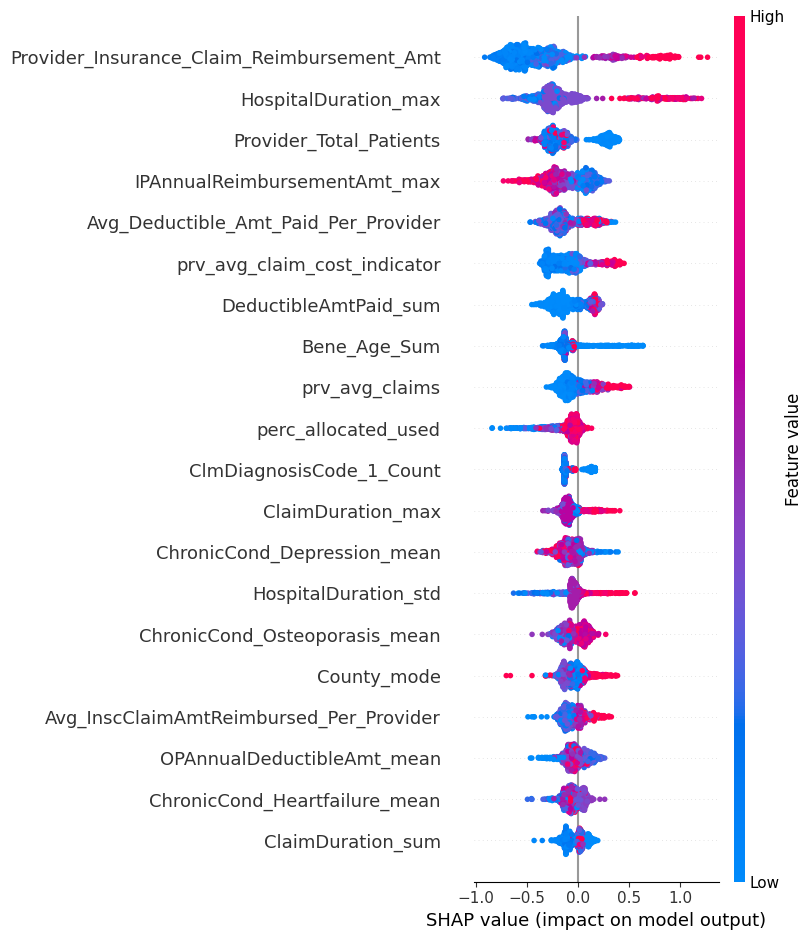

In [63]:
import shap
import xgboost as xgb

# 7.1) Sample a small Pandas subset (max 5,000 rows)
X_test_df = X_test.compute()
X_test_sample = X_test_df.sample(n=min(5000, len(X_test_df)), random_state=42)

# 7.2) Convert to DMatrix
dmatrix_sample = xgb.DMatrix(X_test_sample)

# 7.3) Create a TreeExplainer
explainer = shap.TreeExplainer(bst)

# 7.4) Compute SHAP values
shap_values = explainer.shap_values(dmatrix_sample)

# 7.5) Plot summary
shap.summary_plot(shap_values, X_test_sample)


In [ ]:
'ClmDiagnosisCode_1_Most_Frequent', 'ClaimDuration_mean', 'ChronicCond_Cancer_mean'